In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\carma\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# EDA

In [2]:
df_fraud = pd.read_csv('fraude_tc.csv')

In [3]:
df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


Observo que todos los datos son numéricos y no tengo faltantes. Eso facilita mucho las cosas.

In [4]:
df_fraud.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


De las 8 columnas que tiene el dataset, veo que 5 de ellas son binarias, incluyendo la columna de la clase. También observo que la columna 'Fraud', la clase, está muy imbalanceada. Hasta el percentil 75 contiene valores en 0, aparentemente.<br>
También identifico que las columnas no binarias tienen varianzas muy grandes.

([<matplotlib.patches.Wedge at 0x1733e61f1f0>,
 [Text(-1.058791700494653, 0.29826185636725505, 'Fraud'),
  Text(1.058791700494653, -0.2982618563672552, 'Not Fraud')],
 [Text(-0.5775227457243561, 0.16268828529123003, '91.3%'),
  Text(0.5775227457243561, -0.16268828529123008, '8.7%')])

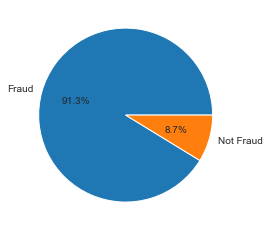

In [5]:
sns.set_style('whitegrid')
plt.pie(df_fraud['fraud'].value_counts(), labels=['Fraud', 'Not Fraud'], autopct='%1.1f%%')

Con este gráfico confirmo la gran diferencia entre los valores fraudulentos y los no fraudulentos. Habrá que utilizar alguna técnica para equilibrar los datos.

In [6]:
#Elimino outliers de todas las columnas, menos la columna de fraud
no_outliers = df_fraud[(np.abs(stats.zscore(df_fraud.iloc[:,:-1])) < 3).all(axis=1)]
outliers = df_fraud[~(np.abs(stats.zscore(df_fraud.iloc[:,:-1])) < 3).all(axis=1)]

([<matplotlib.patches.Wedge at 0x1734094ec10>,
 [Text(-1.0733272386566193, 0.24076677253673717, ''),
  Text(1.073327233021066, -0.24076679765977416, '')],
 [Text(-0.5854512210854286, 0.1313273304745839, '93.0%'),
  Text(0.5854512180114905, -0.1313273441780586, '7.0%')])

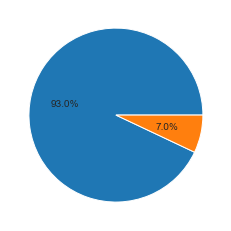

In [7]:
plt.pie(no_outliers['fraud'].value_counts(), autopct='%1.1f%%')

([<matplotlib.patches.Wedge at 0x173409a6130>,
 [Text(-0.11514200673576823, 1.0939571830217398, ''),
  Text(0.11514190431210423, -1.0939571938021078, '')],
 [Text(-0.06280473094678266, 0.5967039180118581, '53.3%'),
  Text(0.06280467507932957, -0.5967039238920587, '46.7%')])

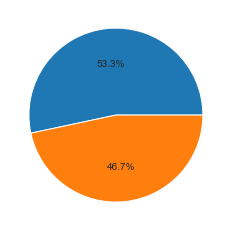

In [8]:
plt.pie(outliers['fraud'].value_counts(), autopct='%1.1f%%')

Al eliminar outliers del dataset veo que la proporción de fraudes se mantiene muy similar. Entre los outliers, los datos se encuentran más balanceados. Me parece que no es necesario eliminar ningún dato.

# Selección del modelo

In [9]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

c:\Users\carma\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [40]:
# Separo los datos en train y test
x = df_fraud.drop(['fraud'], axis=1)
y = df_fraud['fraud']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

Primero crearemos un modelo usando Random Forest con parámetros por defecto. Usaremos class_weight='balanced' para que los datos sean balanceados de manera inversamente proporcional a su frecuencia.

In [36]:
rfc = RandomForestClassifier(n_estimators=500, max_depth=5, random_state=0, class_weight='balanced')
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

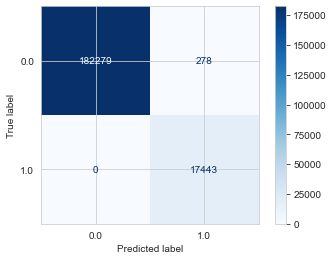

In [37]:
# Muestro la matriz de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.show()

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182557
         1.0       0.98      1.00      0.99     17443

    accuracy                           1.00    200000
   macro avg       0.99      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



In [39]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUC:', roc_auc_score(y_test, y_pred))

Accuracy: 0.99861
AUC: 0.9992385939733892


Obtuve un Accuracy de 0.95. Un valor muy alto. Igualmente, el AUC también es muy bueno.

Ahora procedo a utilizar el XGBClassifier. Similar a Random Forest, pero con más optimización interna.

In [41]:
xgb = XGBClassifier(n_estimators=500, max_depth=5, random_state=0, use_label_encoder=False)
xgb.fit(x_train, y_train)
y_pred_2 = xgb.predict(x_test)

c:\Users\carma\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:33:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


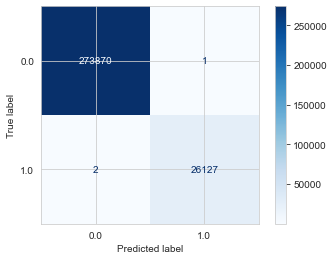

In [42]:
# Muestro la matriz de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_2, cmap='Blues')

In [43]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    273871
         1.0       1.00      1.00      1.00     26129

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000



In [44]:
print('Accuracy:', accuracy_score(y_test, y_pred_2))
print('AUC:', roc_auc_score(y_test, y_pred_2))

Accuracy: 0.99999
AUC: 0.9999599026707605


Obtuve un Accuracy más alto, obteniendo también un alto AUC. La cantidad de falsos positivos bajó muchísimo comparándolo con el modelo anterior, aunque obtuvimos falsos negativos, cosa que no tuvimos con Random Forest. En un entorno real preferiría no tener falsos negativos a la hora de detectar fraudes.